In [390]:
from dotenv import load_dotenv
from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
from pyoso import Client
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../oso_gcp_credentials.json'
GCP_PROJECT = 'opensource-observer'
gcp_client = bigquery.Client(project=GCP_PROJECT)

stringify = lambda arr: "'" + "','".join(arr) + "'"

In [114]:
# Analysis parameters
MOST_RECENT_MEASUREMENT_PERIOD = 5

HISTORIC_START_DATE = "2023-01-01"
HISTORIC_END_DATE   = "2025-06-30"

DAILY_START_DATE = "2025-01-01"
DAILY_END_DATE   = "2025-06-30"

MONTHLY_START_DATE = "2025-01-01"
MONTHLY_END_DATE   = "2025-06-01"

RETROFUNDING_REPO_URL = "https://raw.githubusercontent.com/ethereum-optimism/Retro-Funding/refs/heads/main/results/S7"

OP_RED = "#FF0420"

# Queries

## Projects & Rewards

In [6]:
df_onchain_projects = client.to_pandas("""
   SELECT DISTINCT
     p.project_id AS oso_id,
     p.project_name AS atlas_id,
     p.display_name AS project_name
   FROM projects_v1 AS p
   JOIN projects_by_collection_v1 AS pbc ON p.project_id = pbc.project_id
   JOIN collections_v1 AS c ON pbc.collection_id = c.collection_id
   WHERE c.display_name = 'Retro Funding S7: Onchain Builders'
""")

df_onchain_projects

,oso_id,atlas_id,project_name
0,VTFjeAN76kGnqTqKP+SMe2HPaIKY3wKvwo613l6OWN0=,0x098fca4a62159ddfc2c45dc2931a727d56f039b8f68e...,pods.media
1,ZYxDUEvRWLmr9Tpf2u0ztP2fVUg0H0NLROMVdJQNDRM=,0x260127629089be48b8b1ee07c8962451a7f543741632...,BakerFi
2,5/9fRbVoDF7pHwBdiMbNUbKhidEt/12Ojt9f8cWoZnQ=,0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be...,Velodrome Finance
3,2BzaScISmgDNRXvBgWNUo2ZKEFlNQkQA8fF2BBMicbI=,0x97553b3e60fedc3d6e888c26132dfd49b6bc0174fc45...,Warpslot
4,Jr4krZ4lp1dMiTRDwmF2R9Hw4mF3rsukcBCM4pnF/fc=,0x9d9162fac637991d2a56da8fbe03dba24c87eb82d47c...,Uniswap on Superchain (Oku)
...,...,...,...
320,5usyKOU7bv3X4yyKLIo5UjHOBlFYdm9MbS65dj6i1KE=,0x71235a21ecc7917daf805f832b7e18566f8fefde5ce0...,Unlock Protocol
321,uAWTL5naoNXYNpp7weim8ypopqmN4+H9fO7/1wOjpeA=,0x800707befd6c94e7cea794200a6fee1155e54ca94bc1...,Ethereum Follow Protocol
322,XLvkdswVcDHS98ET9dfOceXRGZFTzV/dYrPUB8DA2Bc=,0x96767e87a27cdb9798f40c3a6fd78e70da611afe53a5...,Sonus Exchange
323,tnIsq+BWiIkXbY18UI8L609BBs89EO4o+MJ3+hmFsAA=,0x9e50828e261179c6d1a5c107c7c2c16907b4b529fef4...,Amazing Hunt


In [7]:
def get_round_results(m_id, category):
    url = f"{RETROFUNDING_REPO_URL}/M{m_id}/outputs/{category}__results.json"
    result = pd.read_json(url)
    result = result[['op_atlas_id', 'op_reward']]
    result.columns = ['atlas_id', 'op_reward']
    result['category'] = category
    result['measurement_period'] = m_id
    return result

def get_all_round_results(category):
    dfs = []
    for m_id in range(1, MOST_RECENT_MEASUREMENT_PERIOD + 1):
        dfs.append(get_round_results(m_id, category))
    return pd.concat(dfs, axis=0, ignore_index=True)

df_onchain_rewards = get_all_round_results("onchain").groupby('atlas_id', as_index=False)['op_reward'].sum()
df_onchain_rewards['is_funded'] = df_onchain_rewards['op_reward'] > 0
df_onchain_rewards

,atlas_id,op_reward,is_funded
0,0x0008577196fa6ec286440b418e2f6305fc10e62ce759...,25173.17,True
1,0x000c2ce4773defb3010a58d3800d0ec9d432189c574b...,30777.19,True
2,0x00d5eaebec0fa6a41bbf5e29d347162dabc04dfffcd1...,56873.92,True
3,0x019ccd1a7cafff57a05d1dc463ad4acd4d138ad4f7c7...,265.25,True
4,0x02065e72fe4eebfa1ebca19238e6147c8571c2b7fefa...,1218.77,True
...,...,...,...
313,0xfd9f98de666c5b0a5ce96d4a4b8d4ceee9f8c2156734...,6286.71,True
314,0xfe8e35b3487bd0e0457b9431b12b73403ca1f5c9c19d...,39491.30,True
315,0xff1edf67227651293a9cff4dce3577c6ca52bf8c7c6f...,24478.28,True
316,0xff350d81524a79a1062f5f4977b45406b822fb4f150b...,0.00,False


## Onchain Metrics

In [328]:
df_daily_metrics_by_chain_and_project = client.to_pandas(f"""
WITH metrics AS (
  SELECT
    metric_id,
    chain, 
    display_name AS metric
  FROM metrics_v0
  CROSS JOIN int_superchain_chain_names AS chains
  WHERE (
    metric_name LIKE '%_transactions_daily'
    OR metric_name LIKE '%_defillama_tvl_daily'
  )
  AND metric_name LIKE CONCAT(chain, '%')
)

SELECT
  tm.sample_date,
  tm.project_id,
  m.chain,
  m.metric,
  SUM(tm.amount) AS amount
FROM timeseries_metrics_by_project_v0 AS tm
JOIN metrics AS m ON tm.metric_id = m.metric_id
WHERE 
  tm.sample_date BETWEEN DATE('{HISTORIC_START_DATE}') AND DATE('{HISTORIC_END_DATE}')
  AND tm.project_id IN ({stringify(df_onchain_projects['oso_id'])})
GROUP BY 1,2,3,4
ORDER BY 1,2,3,4
""")

df_daily_metrics_by_chain_and_project['sample_date'] = pd.to_datetime(df_daily_metrics_by_chain_and_project['sample_date'])
df_daily_metrics_by_chain_and_project

,sample_date,project_id,chain,metric,amount
0,2023-01-01,0eM1b8HKnTMw5hgzgPw3l3m4A4wwTQd/0e1rFWNPz8o=,OPTIMISM,Transactions,4.0
1,2023-01-01,23XIt7EgzQNc2AdcEzTg7GbjT5kKY1lNFfmcGQvrkWA=,BOB,Defillama TVL,44685.79665
2,2023-01-01,23XIt7EgzQNc2AdcEzTg7GbjT5kKY1lNFfmcGQvrkWA=,OPTIMISM,Defillama TVL,3444184.85784
3,2023-01-01,23XIt7EgzQNc2AdcEzTg7GbjT5kKY1lNFfmcGQvrkWA=,OPTIMISM,Transactions,14502.0
4,2023-01-01,5/9fRbVoDF7pHwBdiMbNUbKhidEt/12Ojt9f8cWoZnQ=,OPTIMISM,Defillama TVL,75048565.4008
...,...,...,...,...,...
234208,2025-06-30,yHC4i4mkg5sXaXOF4Mih0UyHDYVS7+0+9zuqnDFvClY=,INK,Transactions,1930.0
234209,2025-06-30,zVWBMiOJHTeEPXEgWSl1B+tsS8W9vwfv2QU32ANB8yY=,BASE,Transactions,1.0
234210,2025-06-30,zdNq7Cvjqx03oRiL22rCANVA7/8MBGaoc3InNwm3LCA=,WORLDCHAIN,Transactions,1.0
234211,2025-06-30,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,BASE,Transactions,13.0


In [63]:
df_monthly_metrics_by_chain_and_project = client.to_pandas(f"""
SELECT
  DATE_FORMAT(sample_date, '%Y-%m-%d') AS sample_date,
  project_id,
  chain,
  metric_name AS metric,
  amount
FROM int_superchain_s7_onchain_metrics_by_project
WHERE
  project_id IN ({stringify(df_onchain_projects['oso_id'])})
  AND sample_date BETWEEN DATE('{MONTHLY_START_DATE}') AND DATE('{MONTHLY_END_DATE}')
ORDER BY 1,2,3,4  
""")
df_monthly_metrics_by_chain_and_project

,sample_date,project_id,chain,metric,amount
0,2025-01-01,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,BASE,active_addresses_monthly,953.0
1,2025-01-01,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,BASE,active_farcaster_users_monthly,59.0
2,2025-01-01,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,BASE,amortized_contract_invocations_monthly,1373.0
3,2025-01-01,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,BASE,average_tvl_monthly,14022271.524434
4,2025-01-01,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,BASE,contract_invocations_monthly,2029.0
...,...,...,...,...,...
37882,2025-06-01,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,ZORA,gas_fees_monthly,0.000006
37883,2025-06-01,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,ZORA,gas_fees_transaction_level_only_monthly,0.000005
37884,2025-06-01,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,ZORA,internal_transactions_monthly,1084.0
37885,2025-06-01,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,ZORA,qualified_addresses_monthly,0.0


In [329]:
df_daily_metrics_by_project = (
    df_daily_metrics_by_chain_and_project
    .groupby(['sample_date', 'project_id', 'metric'], as_index=False)['amount']
    .sum()
)
df_monthly_metrics_by_project = (
    df_monthly_metrics_by_chain_and_project
    .groupby(['sample_date', 'project_id', 'metric'], as_index=False)['amount']
    .sum()
)

## Gas Fees & Deployments

In [53]:
REFRESH = False
if REFRESH:
    df_gas_fees = gcp_client.query(f"""
    WITH projects AS (
      SELECT
        project_id,
        artifact_name AS address,
        artifact_source AS chain
      FROM `oso_production.artifacts_by_project_v1`
      WHERE project_id IN ({stringify(df_onchain_projects['oso_id'])})
    ),
    txns AS (
      SELECT
        dt,
        to_address,
        CASE
          WHEN chain = 'op' THEN 'OPTIMISM'
          WHEN chain = 'fraxtal' THEN 'FRAX'
          ELSE UPPER(chain)
        END AS chain,
        (receipt_gas_used / 1e18 * receipt_effective_gas_price) AS gas_fee
      FROM `optimism_superchain_raw_onchain_data.transactions`
      WHERE dt >= '{HISTORIC_START_DATE}'
    )    
    SELECT
      txns.dt,
      projects.project_id,
      txns.chain,
      SUM(gas_fee) AS gas_fees
    FROM txns
    JOIN projects
      ON
        txns.to_address = projects.address
        AND txns.chain = projects.chain
    GROUP BY 1,2,3
    """).to_dataframe()
    df_gas_fees.to_parquet('data/20250714_s7_onchain_builder_gasfees.parquet')
else:
    df_gas_fees = pd.read_parquet('data/20250714_s7_onchain_builder_gasfees.parquet')

df_gas_fees    

,dt,project_id,chain,gas_fees
0,2025-02-13,rxrN8HnLLV8SOP3md3NfXpntywh7F7n5fuRMqFB3Upo=,METAL,1.769197e-07
1,2025-04-21,/2hjsm9xH1NvgIs/dHx5VOVM4ml/C6hfQu97wBgdpfo=,AUTOMATA,4.556088e-06
2,2024-12-04,vCa+wBp0799NJ8j9L6UgKxKmqiLT95Zk/aQX/hXty7c=,HAM,1.577239e-05
3,2024-12-27,rxrN8HnLLV8SOP3md3NfXpntywh7F7n5fuRMqFB3Upo=,METAL,5.405441e-08
4,2024-10-06,shVzoDEk43o/o3eLSpahwHfj/tn5zrcHqS8SYUzufrA=,HAM,5.008999e-11
...,...,...,...,...
211195,2023-11-02,VuCrFAWDzI1K7USE+kh9ECxcEa/iG9eVHG6EMS/8iS4=,ZORA,1.866639e-03
211196,2025-06-22,JvriFQ0NlFxB3+GIDPJQShc9f52TRc/cmOcLdzUPgL4=,ZORA,1.138083e-10
211197,2025-03-29,JvriFQ0NlFxB3+GIDPJQShc9f52TRc/cmOcLdzUPgL4=,ZORA,6.969084e-10
211198,2025-04-18,vCa+wBp0799NJ8j9L6UgKxKmqiLT95Zk/aQX/hXty7c=,ZORA,1.234306e-06


In [54]:
df_all_contracts = client.to_pandas(f"""
  SELECT
    abp.artifact_source AS chain,
    COUNT(DISTINCT atlas.artifact_id) AS verified_contracts,
    APPROX_DISTINCT(abp.artifact_id) AS all_contracts
  FROM artifacts_by_project_v1 AS abp
  LEFT JOIN int_artifacts_by_project_in_op_atlas AS atlas
    ON abp.artifact_id = atlas.artifact_id
    AND abp.project_id = atlas.project_id
    AND atlas.artifact_type = 'CONTRACT'
  WHERE
    abp.project_id IN ({stringify(df_onchain_projects['oso_id'])})
    AND abp.artifact_source IN ({stringify(df_gas_fees['chain'].unique())})
  GROUP BY 1
  ORDER BY 2 DESC
""")

df_all_contracts

,chain,verified_contracts,all_contracts
0,BASE,8742,2686110
1,OPTIMISM,2400,88745
2,SONEIUM,1071,357981
3,ZORA,765,71726
4,MINT,545,42706
5,MODE,458,14975
6,WORLDCHAIN,402,97233
7,LISK,351,171392
8,BOB,292,9198
9,INK,265,214214


## Baseline Comparisons

In [408]:
_superchain_set = list(df_gas_fees['chain'].unique()) + ['WORLD CHAIN', 'FRAXTAL']
_comp_set = ['ETHEREUM', 'ARBITRUM']
_relevant_chains = superchain_set + comp_set

df_chain_tvl = gcp_client.query(f"""
SELECT
  DATE(time) AS sample_date,
  'Defillama TVL' AS metric,
  UPPER(chain) AS chain,
  UPPER(chain) IN ({stringify(_superchain_set)}) AS is_superchain,
  tvl AS amount
FROM `defillama.historical_chain_tvl`
WHERE
  DATE(time) BETWEEN '{HISTORIC_START_DATE}' AND '{HISTORIC_END_DATE}'
  AND UPPER(chain) IN ({stringify(_relevant_chains)})
ORDER BY 1,2,3
""").to_dataframe()
df_chain_tvl

,sample_date,metric,chain,is_superchain,amount
0,2023-01-01,Defillama TVL,ARBITRUM,False,1.003863e+09
1,2023-01-01,Defillama TVL,ETHEREUM,False,2.210950e+10
2,2023-01-01,Defillama TVL,OPTIMISM,True,4.885837e+08
3,2023-01-01,Defillama TVL,POLYGON,False,9.175063e+08
4,2023-01-02,Defillama TVL,ARBITRUM,False,1.005119e+09
...,...,...,...,...,...
8705,2025-06-30,Defillama TVL,POLYNOMIAL,True,6.468469e+06
8706,2025-06-30,Defillama TVL,SONEIUM,True,1.307802e+08
8707,2025-06-30,Defillama TVL,UNICHAIN,True,8.750774e+08
8708,2025-06-30,Defillama TVL,WORLD CHAIN,True,4.422286e+07


In [410]:
df_chain_other_metrics = gcp_client.query(f"""
SELECT
  date AS sample_date,
  CASE WHEN metric_key = 'txcount' THEN 'Transactions' ELSE 'Market Cap USD' END AS metric,
  UPPER(origin_key) AS chain,
  UPPER(origin_key) IN ({stringify(_superchain_set)}) AS is_superchain,
  value AS amount
FROM `growthepie.fundamentals_full`
WHERE 
  metric_key IN ('txcount', 'market_cap_usd')
  AND DATE(date) BETWEEN '{HISTORIC_START_DATE}' AND '{HISTORIC_END_DATE}'
  AND UPPER(origin_key) IN ({stringify(_relevant_chains)})
ORDER BY 1,2
""").to_dataframe()
df_chain_other_metrics

,sample_date,metric,chain,is_superchain,amount
0,2023-01-01,Market Cap USD,ETHEREUM,False,1.441888e+11
1,2023-01-01,Market Cap USD,OPTIMISM,True,1.970818e+08
2,2023-01-01,Transactions,ARBITRUM,False,1.587310e+05
3,2023-01-01,Transactions,ETHEREUM,False,7.427850e+05
4,2023-01-01,Transactions,OPTIMISM,True,3.766510e+05
...,...,...,...,...,...
13570,2025-06-30,Transactions,SONEIUM,True,2.373204e+06
13571,2025-06-30,Transactions,SWELL,True,4.601800e+04
13572,2025-06-30,Transactions,UNICHAIN,True,1.520956e+06
13573,2025-06-30,Transactions,WORLDCHAIN,True,1.469165e+06


In [411]:
df_chain_metrics = pd.concat([df_chain_tvl, df_chain_other_metrics], axis=0, ignore_index=True)
df_chain_metrics

,sample_date,metric,chain,is_superchain,amount
0,2023-01-01,Defillama TVL,ARBITRUM,False,1.003863e+09
1,2023-01-01,Defillama TVL,ETHEREUM,False,2.210950e+10
2,2023-01-01,Defillama TVL,OPTIMISM,True,4.885837e+08
3,2023-01-01,Defillama TVL,POLYGON,False,9.175063e+08
4,2023-01-02,Defillama TVL,ARBITRUM,False,1.005119e+09
...,...,...,...,...,...
22280,2025-06-30,Transactions,SONEIUM,True,2.373204e+06
22281,2025-06-30,Transactions,SWELL,True,4.601800e+04
22282,2025-06-30,Transactions,UNICHAIN,True,1.520956e+06
22283,2025-06-30,Transactions,WORLDCHAIN,True,1.469165e+06


# Transformations

## Project Derived Metrics

In [412]:
df_monthly_pre_post_metrics = (
    df_monthly_metrics_by_project
    .loc[lambda d: d.sample_date.isin([MONTHLY_START_DATE, MONTHLY_END_DATE])]
    .pivot_table(
        index=["project_id", "metric"],
        columns="sample_date",
        values="amount",
        fill_value=0
    )
    .rename_axis(None, axis=1)
    .rename(columns={
        MONTHLY_START_DATE: "pre",
        MONTHLY_END_DATE: "post"
    })
    .assign(delta=lambda d: d.post - d.pre)
    .reset_index()
)
df_monthly_pre_post_metrics

,project_id,metric,pre,post,delta
0,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,active_addresses_monthly,953.0,1322.0,369.0
1,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,active_farcaster_users_monthly,59.0,104.0,45.0
2,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,active_upgraded_eoa_addresses_monthly,0.0,24.0,24.0
3,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,amortized_contract_invocations_monthly,1373.0,2518.5,1145.5
4,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,average_tvl_monthly,14022271.524434,6220171.695699,-7802099.828735
...,...,...,...,...,...
3269,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,gas_fees_monthly,0.003437,0.001905,-0.001532
3270,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,gas_fees_transaction_level_only_monthly,0.003354,0.001896,-0.001458
3271,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,internal_transactions_monthly,943.0,1731.0,788.0
3272,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,qualified_addresses_monthly,30.0,33.0,3.0


In [413]:
df_project_metrics_pivoted = (
    df_onchain_projects.set_index('atlas_id')[['project_name']]
    #.join(df_devtool_labels.set_index('atlas_id')[['category_label']])
    .join(df_onchain_rewards.set_index('atlas_id'))
    #.join(df_devtools_enriched)
    #.join(df_center_of_gravity_by_project.set_index('atlas_id'))
    .sort_values(by='op_reward', ascending=False)
)
df_project_metrics_pivoted['op_reward'].fillna(0, inplace=True)
df_project_metrics_pivoted['is_funded'].fillna(False, inplace=True)
df_project_metrics_pivoted

,project_name,op_reward,is_funded
atlas_id,,,
0x4288aacdda65af69c03b2c9b9d057e2b93ed1b7671e481b03c6a7b33349d2365,Aerodrome Finance,330000.01,True
0x9d9162fac637991d2a56da8fbe03dba24c87eb82d47c7a00b921e39e956f8a9d,Uniswap on Superchain (Oku),330000.01,True
0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be0f3ad513db6f13c755dd,Velodrome Finance,309942.89,True
0xb98778ca9ff41446e2bc304f7b5d27f0fa7c2bcd11df19e22d1352c06698a1f6,Account Abstraction - ERC-4337,283908.39,True
0x3061b642db56c507e265f03029735b0413a613bda43456a31e78128baeb18754,Aave,242998.59,True
...,...,...,...
0xb0a62ebee7f20fd4c4bf96822c062b5fc13e7865702a9abfa49e02549418cffc,Bloom,0.00,False
0x3b0cbf113357776ebfee5800bc483fd4de6e1d2fa3fa1053dd7d17ec924f668d,Lakewood Hills Collective & CMNG (CCG),0.00,False
0x1a071a609b8534e8345d1ba86db104969471a43c5c5b047105ba3b1a49de78a1,WillWe,0.00,False


## Descriptive Stats

In [414]:
print("Total OP:", df_project_metrics_pivoted['op_reward'].sum().astype(int))
print("Funded:", len(df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]))
print("Applicants:", len(df_project_metrics_pivoted))

Total OP: 6579609
Funded: 200
Applicants: 325


In [415]:
print(df_gas_fees['gas_fees'].sum())
df_gas_fees[df_gas_fees['dt'].between(pd.to_datetime(ONCHAIN_START_DATE), pd.to_datetime(ONCHAIN_END_DATE))]['gas_fees'].sum()

4433.532514483267


1144.702474673062

In [416]:
print(df_all_contracts['verified_contracts'].sum())
print(df_all_contracts['all_contracts'].sum())

15645
3955811


In [417]:
print("Median OP:", df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['op_reward'].median())
max_op = round(df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['op_reward'].max())
print("Max OP:", max_op)
for x in sorted(df_project_metrics_pivoted[df_project_metrics_pivoted['op_reward'] >= max_op]['project_name'].unique()):
    print(" -", x)

Median OP: 9078.119999999999
Max OP: 330000
 - Aerodrome Finance
 - Uniswap on Superchain (Oku)


In [418]:
# (
#     df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]
#     .groupby('is_eligible_package')['op_reward']
#     .agg(['count', 'sum', 'median'])
#     .apply(round)
#     .astype(int)
# )

In [419]:
# for x in df_project_metrics_pivoted[~df_project_metrics_pivoted['is_eligible_package']]['project_name'].head(5):
#     print(" -", x)

In [420]:
# print("Median age (years):", df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['years_old'].median())
# print("Median active devs:", df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['avg_active_devs'].median())

In [421]:
# (
#     df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]
#     .groupby('older_than_3_years')['op_reward'].agg(['count', 'sum', 'median'])
# )

In [422]:
df_daily_metrics_by_chain = (
    df_daily_metrics_by_chain_and_project
    .groupby(['sample_date', 'metric', 'chain'], as_index=False)['amount']
    .sum()
)
df_daily_metrics_by_chain

,sample_date,metric,chain,amount
0,2023-01-01,Defillama TVL,BOB,2060576.59497
1,2023-01-01,Defillama TVL,OPTIMISM,242344134.0411
2,2023-01-01,Transactions,OPTIMISM,46024.0
3,2023-01-02,Defillama TVL,BOB,2059826.87554
4,2023-01-02,Defillama TVL,OPTIMISM,242088751.99982
...,...,...,...,...
13306,2025-06-30,Transactions,SWAN,14.0
13307,2025-06-30,Transactions,SWELL,384.0
13308,2025-06-30,Transactions,UNICHAIN,22136.0
13309,2025-06-30,Transactions,WORLDCHAIN,73974.0


## Synthetic Control Timeseries

In [423]:
_df_superchain_metrics = df_daily_metrics_by_chain.groupby(['sample_date', 'metric'], as_index=False)['amount'].sum()
_df_superchain_metrics['cohort'] = 'Retro Funded Projects'
_df_superchain_metrics.sort_values(by='sample_date')

,sample_date,metric,amount,cohort
0,2023-01-01,Defillama TVL,244404710.63607,Retro Funded Projects
1,2023-01-01,Transactions,46024.0,Retro Funded Projects
2,2023-01-02,Defillama TVL,244148578.87536,Retro Funded Projects
3,2023-01-02,Transactions,48960.0,Retro Funded Projects
4,2023-01-03,Defillama TVL,246502662.372,Retro Funded Projects
...,...,...,...,...
1818,2025-06-28,Transactions,1700407.0,Retro Funded Projects
1819,2025-06-29,Defillama TVL,4722211199.17599,Retro Funded Projects
1820,2025-06-29,Transactions,1588262.0,Retro Funded Projects
1821,2025-06-30,Defillama TVL,4802167844.19026,Retro Funded Projects


In [424]:
_df_comp_metrics = pd.concat([df_chain_other_metrics, df_chain_tvl], axis=0, ignore_index=True)
_df_comp_metrics['cohort'] = _df_comp_metrics.apply(
    lambda x: 'Superchain' if x['is_superchain'] else x['chain'].title(), axis=1
)
_df_comp_metrics = _df_comp_metrics.groupby(['sample_date', 'metric', 'cohort'], as_index=False)['amount'].sum()
_df_comp_metrics['sample_date'] = pd.to_datetime(_df_comp_metrics['sample_date'])
_df_comp_metrics

,sample_date,metric,cohort,amount
0,2023-01-01,Defillama TVL,Arbitrum,1.003863e+09
1,2023-01-01,Defillama TVL,Ethereum,2.210950e+10
2,2023-01-01,Defillama TVL,Polygon,9.175063e+08
3,2023-01-01,Defillama TVL,Superchain,4.885837e+08
4,2023-01-02,Defillama TVL,Arbitrum,1.005119e+09
...,...,...,...,...
9034,2025-06-30,Market Cap USD,Ethereum,3.021583e+11
9035,2025-06-30,Market Cap USD,Superchain,7.383600e+09
9036,2025-06-30,Transactions,Arbitrum,2.898580e+06
9037,2025-06-30,Transactions,Ethereum,1.427448e+06


In [425]:
def add_non_retro_funded_cohort(df):
 
    df_filtered = df[df.metric.isin(['Transactions', 'Defillama TVL'])].copy()
    pivot = df_filtered.pivot_table(
        index=['sample_date', 'metric'],
        columns='cohort',
        values='amount'
    ).reset_index()
    pivot['Superchain - Not Retro Funded'] = (
        pivot['Superchain'] - pivot['Retro Funded Projects']
    )
    new_cohort = pivot.melt(
        id_vars=['sample_date', 'metric'],
        value_vars=['Superchain - Not Retro Funded'],
        var_name='cohort',
        value_name='amount'
    )
    result = pd.concat([df, new_cohort], ignore_index=True)
    result = result.sort_values(['sample_date', 'metric', 'cohort'])
    return result

df_syncon_timeseries = (
    pd.concat([_df_comp_metrics, _df_superchain_metrics], axis=0, ignore_index=True)
    .sort_values(by='sample_date')
)
df_syncon_timeseries = add_non_retro_funded_cohort(df_syncon_timeseries)

df_syncon_timeseries[df_syncon_timeseries['sample_date'] == '2025-06-30']

,sample_date,metric,cohort,amount
10858,2025-06-30,Defillama TVL,Arbitrum,2503380460.0
10856,2025-06-30,Defillama TVL,Ethereum,63438902709.0
10850,2025-06-30,Defillama TVL,Polygon,1077224897.0
10857,2025-06-30,Defillama TVL,Retro Funded Projects,4802167844.19026
10859,2025-06-30,Defillama TVL,Superchain,5065466709.0
12684,2025-06-30,Defillama TVL,Superchain - Not Retro Funded,263298864.80974
10855,2025-06-30,Market Cap USD,Arbitrum,1834133586.723221
10854,2025-06-30,Market Cap USD,Ethereum,302158279316.216736
10853,2025-06-30,Market Cap USD,Superchain,7383600173.896551
10852,2025-06-30,Transactions,Arbitrum,2898580.0


# Visualizations

In [473]:
from matplotlib.ticker import FuncFormatter

def human_format(num):
    for unit in ['','K','M','B','T']:
        if abs(num) < 1000:
            return f"{num:.1f}{unit}"
        num /= 1000
    return f"{num:.1f}P"

## Synthetic Control

In [474]:
from pysyncon import Dataprep, Synth

def create_synth_control(
    df_timeseries,
    dependent_metric,
    predictor_metrics,
    control_entity_list,
    treatment_entity,
    time_predictors_prior_start=HISTORIC_START_DATE,
    time_predictors_prior_end=DAILY_START_DATE,
    time_optimize_ssr_start=DAILY_START_DATE,
    time_optimize_ssr_end=DAILY_END_DATE,
    predictors_op='mean',
    date_col='sample_date',
    entity_col='cohort',
    metric_col='metric',
    value_col='amount',
    baseline_date=DAILY_START_DATE
):
    df_wide = df_timeseries.pivot(
        index=[date_col, entity_col],
        columns=metric_col,
        values=value_col
    ).fillna(0).reset_index()
    time_predictors = pd.date_range(time_predictors_prior_start, time_predictors_prior_end, freq='D')
    time_optimize = pd.date_range(time_optimize_ssr_start, time_optimize_ssr_end, freq='D')
    dp = Dataprep(
        foo=df_wide,
        predictors=predictor_metrics,
        predictors_op=predictors_op,
        time_predictors_prior=time_predictors,
        time_optimize_ssr=time_optimize,
        dependent=dependent_metric,
        unit_variable=entity_col,
        time_variable=date_col,
        treatment_identifier=treatment_entity,
        controls_identifier=control_entity_list
    )
    synth = Synth()
    synth.fit(dp)
    weights = {k: round(float(v), 3) for k, v in synth.weights().items()}
    plot_dates = pd.date_range(df_wide[date_col].min(), df_wide[date_col].max(), freq='D')
    Z0, Z1 = dp.make_outcome_mats(plot_dates)
    synthetic = synth._synthetic(Z0)
    data = [
        {
            'date': d.strftime('%Y-%m-%d'),
            'treatment': None if pd.isna(t) else float(t),
            'synthetic': None if pd.isna(syn) else float(syn)
        }
        for d, t, syn in zip(plot_dates, Z1, synthetic)
    ]
    base = next((r for r in data if r['date'] == baseline_date), None)
    if base:
        b_t = base['treatment'] or 0
        b_s = base['synthetic'] or 0
        ratio = b_t / b_s if b_s else None
        for r in data:
            r['synthetic_adj'] = None if r['synthetic'] is None or ratio is None else float(r['synthetic'] * ratio)
    return {'weights': weights, 'data': data}

In [517]:
def plot_synthetic_control(
    df_timeseries,
    dependent_metric='Defillama TVL',
    predictor_metrics=['Market Cap USD', 'Defillama TVL'],
    control_entity_list=['Arbitrum'],
    treatment_entity='Retro Funded Projects',
    adjusted=True
):

    response = create_synth_control(
        df_timeseries=df_timeseries,
        dependent_metric=dependent_metric,
        predictor_metrics=predictor_metrics,
        control_entity_list=control_entity_list,
        treatment_entity=treatment_entity
    )
    
    df = pd.DataFrame(response['data']).dropna().copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'].between(pd.to_datetime(DAILY_START_DATE), pd.to_datetime('2025-07-01'))]
    
    fig, ax = plt.subplots(figsize=(10, 5))

    _treat_label = f"Treatment ({treatment_entity})"
    _control_label = f"Control ({', '.join(control_entity_list)})"
    _control_col = 'synthetic_adj' if adjusted else 'synthetic'
    
    sns.lineplot(data=df, x='date', y='treatment', label=_treat_label, color='#ff0420', linewidth=1)
    sns.lineplot(data=df, x='date', y=_control_col, label=_control_label, color='black', linewidth=1)

    _title = f"{dependent_metric}: synthetic control analysis"
    ax.set_title(_title, weight='bold', loc='left')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax.set_xlim(pd.to_datetime(DAILY_START_DATE), pd.to_datetime('2025-07-01'))
    
    ax.legend(frameon=True, loc='upper left')
    
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate(rotation=30, ha='right')
    
    ax.fill_between(
        df['date'],
        df['treatment'],
        df[_control_col],
        where=(df['treatment'] > df[_control_col]),
        interpolate=True,
        color='#ff0420',
        alpha=0.1,
        label='Treatment > Synthetic Control'
    )
    
    ax.fill_between(
        df['date'],
        df['treatment'],
        df[_control_col],
        where=(df['treatment'] <= df[_control_col]),
        interpolate=True,
        color='black',
        alpha=0.05,
        label='Synthetic Control ≥ Treatment'
    )

    ymin = min(df['treatment'].min(), df[_control_col].min()) * 0.75
    ymax = max(df['treatment'].max(), df[_control_col].max()) * 1.2
    ax.set_ylim(ymin, ymax)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: human_format(x)))
    
    plt.tight_layout()
    plt.show()

In [518]:
df_syncon_timeseries['cohort'].unique()

array(['Arbitrum', 'Ethereum', 'Polygon', 'Retro Funded Projects',
       'Superchain', 'Superchain - Not Retro Funded'], dtype=object)

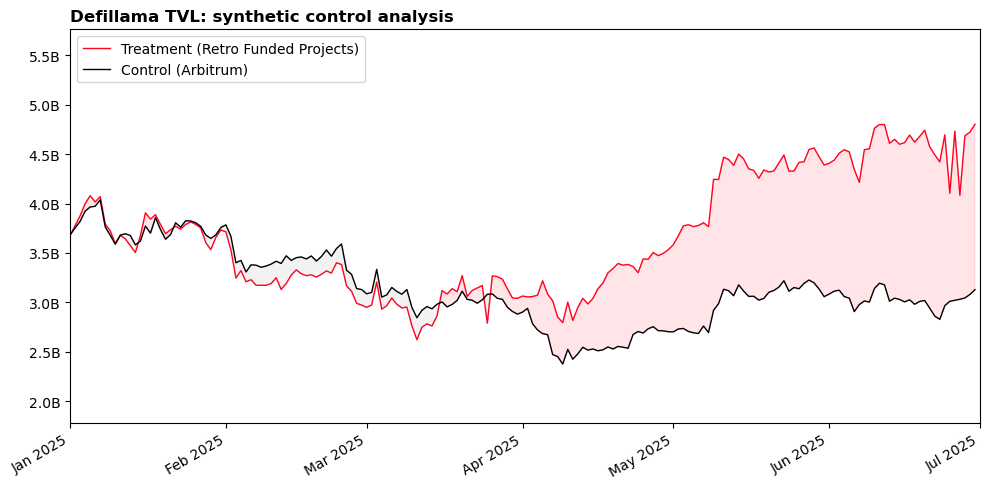

In [528]:
plot_synthetic_control(
    df_syncon_timeseries,
    dependent_metric='Defillama TVL',
    predictor_metrics=['Market Cap USD', 'Defillama TVL'],
    control_entity_list=['Arbitrum'],
    treatment_entity='Retro Funded Projects'
)

In [ ]:
df

## Observational

In [116]:
_median_reward = df_onchain_rewards[df_onchain_rewards['is_funded'] == True]['op_reward'].median()
_target_atlas_ids = list(df_onchain_rewards[df_onchain_rewards['op_reward'] >= _median_reward]['atlas_id'].unique())
_target_oso_ids = list(df_onchain_projects[df_onchain_projects['atlas_id'].isin(_target_atlas_ids)]['oso_id'].unique())

In [172]:
_target_metrics = [
    'average_tvl_monthly',
    
    'transactions_monthly',
    'internal_transactions_monthly',
    'account_abstraction_userops_monthly',
    
    'active_upgraded_eoa_addresses_monthly',
    'contract_invocations_upgraded_eoa_monthly',
    
    'active_worldchain_verified_addresses_monthly',
    'worldchain_events_monthly',

    'active_addresses_monthly',
    'active_farcaster_users_monthly'
]

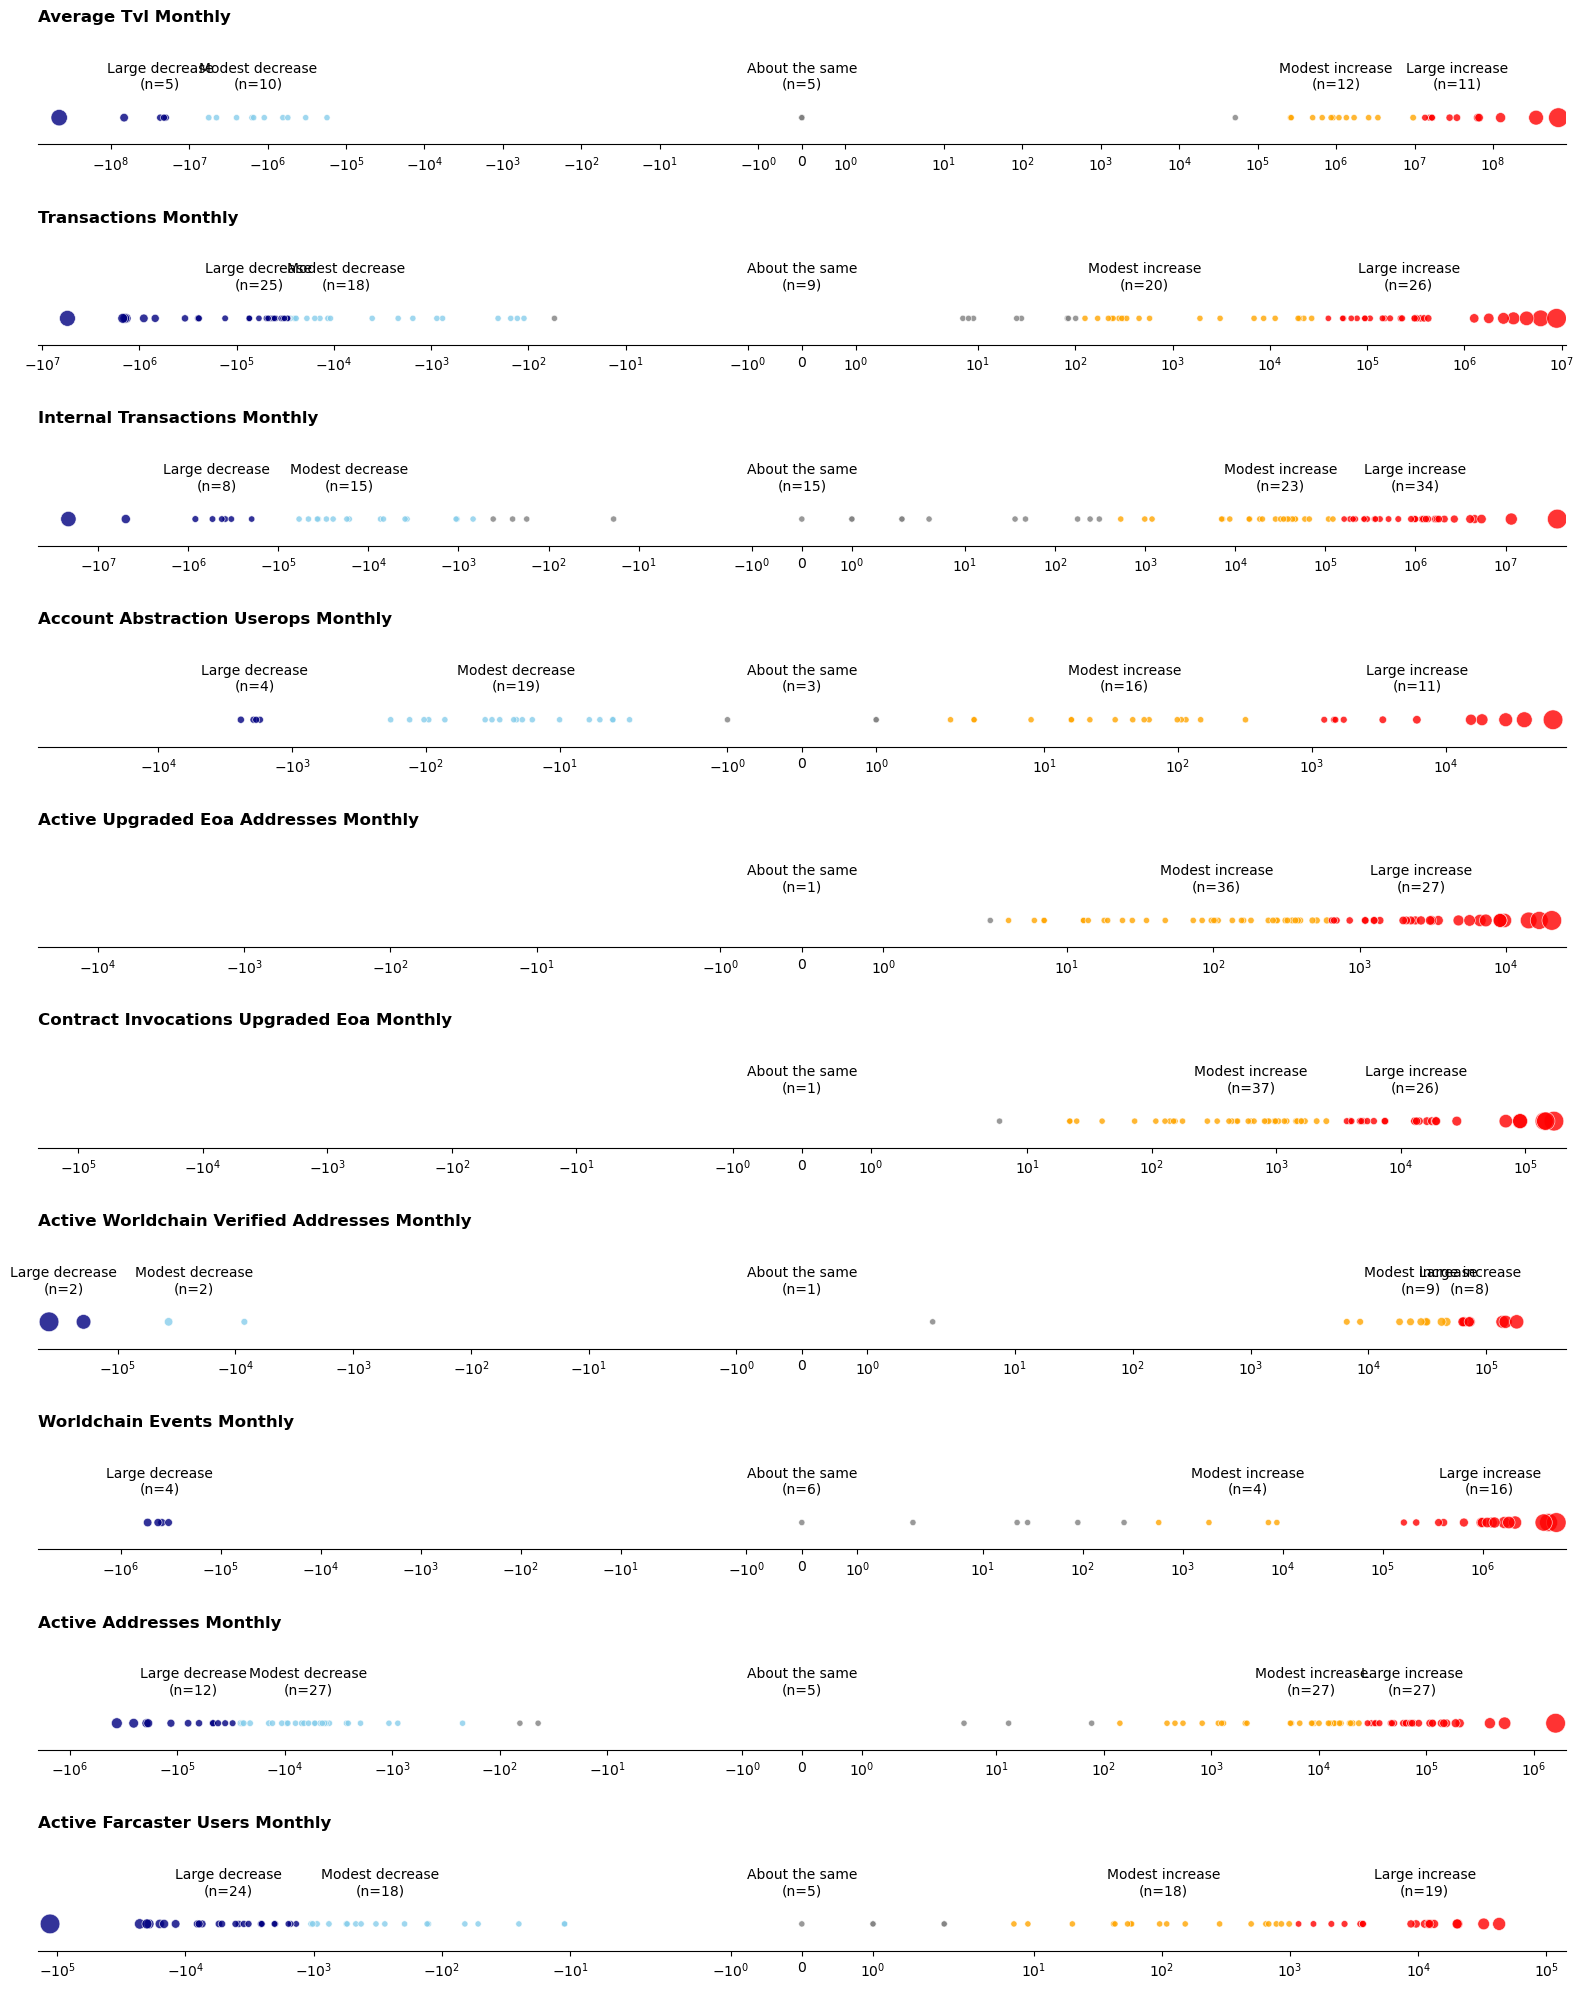

In [174]:
def impact_vector_five_categories(
    df_pre_post,
    metric,
    ax=None,
    val_col='delta',
    title=None
):
    """
    Scatter raw delta into five categories, treating 'about the same' as |delta| <= zero_thresh,
    draw threshold lines at mean, sig1, sig2, and annotate counts per category.

    Categories:
      - Large decrease: delta < -sig1
      - Modest decrease: -sig1 <= delta < -zero_thresh
      - About the same: |delta| <= zero_thresh
      - Modest increase: zero_thresh < delta <= sig1
      - Large increase: delta > sig1

    Args:
      df_pre_post (pd.DataFrame): must contain ['metric', val_col]
      metric (str)
      ax (matplotlib Axes)
      val_col (str): column for raw delta
      zero_thresh (float): threshold around zero; defaults to 5% of mean
      title (str)

    Returns:
      fig
    """
    # raw series
    series = (
        df_pre_post
        .loc[df_pre_post['metric'] == metric, val_col]
        .dropna()
        .astype(float)
    )

    # compute positive-side thresholds
    pos    = series[series > 0]
    logpos = np.log(pos)
    mu, sigma = logpos.mean(), logpos.std()
    mean = np.exp(mu)
    sig1 = np.exp(mu + 0.25 * sigma)
    sig2 = np.exp(mu + sigma)

    zero_thresh = mean * 0.01

    # define categories
    labels = [
        'Large decrease',
        'Modest decrease',
        'About the same',
        'Modest increase',
        'Large increase'
    ]
    cats = pd.Series(index=series.index, dtype='category')
    cats = cats.cat.set_categories(labels, ordered=True)
    cats.loc[series < -sig1] = 'Large decrease'
    cats.loc[(series >= -sig1) & (series < -zero_thresh)] = 'Modest decrease'
    cats.loc[(series >= -zero_thresh) & (series <= zero_thresh)] = 'About the same'
    cats.loc[(series > zero_thresh) & (series <= sig1)] = 'Modest increase'
    cats.loc[series > sig1] = 'Large increase'

    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 20/8), facecolor='white')
    else:
        fig = ax.figure

    palette = {
        'Large decrease': 'navy',
        'Modest decrease': 'skyblue',
        'About the same': 'grey',
        'Modest increase': 'orange',
        'Large increase': 'red'
    }
    sns.scatterplot(
        x=series,
        y=[0] * len(series),
        hue=cats,
        palette=palette,
        size=series.abs(),
        sizes=(20, 200),
        edgecolor='w',
        linewidth=0.5,
        alpha=0.8,
        legend=False,
        ax=ax
    )

    counts = cats.value_counts().reindex(labels).fillna(0)
    for label in labels:
        count = counts[label]
        if count > 1 or label == 'About the same':
            x_med = series[cats == label].median()
            if label == 'About the same':
                x_med = 0
            ax.text(
                x_med,
                1,
                f"{label}\n(n={count})",
                ha='center',
                va='bottom',
                fontsize=10
            )
    ax.set_ylim(-1, 2)
    
    xmin = series.min()
    xmin = min(0,xmin - abs(xmin) * 0.25)
    xmax = series.max()
    xmax = xmax + abs(xmax) * 0.25
    ax.set_xscale('symlog')

    if xmax > abs(xmin):
        ax.set_xlim(-xmax, xmax)
    else:
        ax.set_xlim(xmin, abs(xmin))
    
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(
        title + "\n\n",
        loc='left',
        fontsize=12,
        fontweight='bold'
    )
    for sp in ['top', 'right', 'left']:
        ax.spines[sp].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.xaxis.set_ticks_position('bottom')

W,H = 16,20
fig, axes = plt.subplots(figsize=(W,H), ncols=1, nrows=len(_target_metrics), facecolor='white')

for (i,metric_name) in enumerate(_target_metrics):
    impact_vector_five_categories(
        df_pre_post=df_monthly_pre_post_metrics[df_monthly_pre_post_metrics['project_id'].isin(_target_oso_ids)],
        metric=metric_name,
        ax=axes[i]
    ) 

fig.tight_layout()
fig.subplots_adjust(hspace=1.5)

In [246]:
_fmt = lambda x: f"{x}" if isinstance(x, str) or x < 1000 else f"{x/1000:.0f}K"

_category_summary = (
    df_project_metrics_pivoted
    .groupby('category_label')[['project_name']]
    .count()
    .rename(columns={'project_name': 'applicants'})
    .join(
        df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded'] == True]
        .groupby('category_label')
        .agg(
            num_projects = ('project_name','count'),
            median_op    = ('op_reward',   'median'),        
            total_op     = ('op_reward',   'sum')     
        )
    )
    .fillna(0)
    .sort_values(by='total_op', ascending=False)
)
_category_summary['share'] = (_category_summary['total_op'] / _category_summary['total_op'].sum()).apply(lambda x: f"{x*100:.1f}%")
_category_summary = _category_summary[['applicants', 'num_projects', 'median_op', 'total_op', 'share']].applymap(_fmt).reset_index()
print(_category_summary.to_markdown(index=False, tablefmt='github'))

| category_label                     |   applicants |   num_projects | median_op   | total_op   | share   |
|------------------------------------|--------------|----------------|-------------|------------|---------|
| Core Protocol Interfaces           |           39 |             23 | 60K         | 2384K      | 36.1%   |
| Development Frameworks             |           12 |              7 | 70K         | 688K       | 10.4%   |
| Cryptography & Primitives          |            7 |              6 | 98K         | 574K       | 8.7%    |
| Developer Experience Tools         |           36 |             14 | 12K         | 548K       | 8.3%    |
| Language & Compilation Tools       |            7 |              6 | 42K         | 528K       | 8.0%    |
| Infrastructure & Node Operations   |           16 |              9 | 34K         | 469K       | 7.1%    |
| Testing & Verification Tools       |           16 |             12 | 9K          | 455K       | 6.9%    |
| Data Indexing & Analytics 

# Scratchpad?

In [193]:
CHAIN_PALETTE = {
    'OPTIMISM': '#ff0420',
    'ZORA': 'indigo',
    'BASE': '#0052FF',
    'MODE': '#DFFE00',
    'WORLDCHAIN': '#FF6F0F',
    'INK': '#7132F5',
    'SONEIUM': '#57F8FE',
    'UNICHAIN': '#FF007A',
    'OTHERS': '#aaa'
}
CHAIN_PALETTE = {k.title(): v for k, v in CHAIN_PALETTE.items()}
CHAIN_ORDER = ['OPTIMISM', 'BASE', 'MODE', 'WORLDCHAIN', 'SONEIUM', 'INK', 'UNICHAIN', 'ZORA', 'OTHERS']
CHAIN_ORDER = [c.title() for c in CHAIN_ORDER]

In [194]:


    
k_formatter = mticker.FuncFormatter(lambda y, _: f"{int(y/1000)}K")